# TF-IDF Baselines: Logistic Regression and Linear SVM

**Goal.** Fit strong linear baselines with TF-IDF uni-grams and bi-grams, pick thresholds on validation, and evaluate on test with clear plots and saved artifacts.


In [ ]:
from pathlib import Path
import os, sys, json, importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.ticker import PercentFormatter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    average_precision_score, roc_auc_score, brier_score_loss,
    precision_recall_curve, precision_recall_fscore_support, accuracy_score
)
import joblib


In [ ]:
from google.colab import drive

drive.mount("/content/drive")
plt.rcParams["figure.dpi"] = 150

# project root + src
CANDIDATES = [
    Path("/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project"),
    Path("/content/drive/masters_math/capestone/Final_project/Final_project"),
]
PROJECT_ROOT = next((p for p in CANDIDATES if (p/"src"/"utilities.py").exists()), None)
assert PROJECT_ROOT, "Couldn't find src/utilities.py. Check the Drive path."

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
importlib.invalidate_caches()
import src; importlib.reload(src)

from src import (
    set_seed, ensure_dir, save_json,
    build_tfidf, threshold_sweep, pick_thr_with_recall_floor, eval_binary,
    plot_pr_roc, plot_calibration, plot_confusion, plot_threshold_sweep,
    compute_class_weights, choose_text_col, save_probs_csv
)

ARTIFACTS_DIR = ensure_dir(PROJECT_ROOT / "artifacts")
PLOTS_DIR     = ensure_dir(PROJECT_ROOT / "plots")
TFIDF_DIR     = ensure_dir(ARTIFACTS_DIR / "baselines" / "tfidf")

set_seed(42)
print({"artifacts": str(ARTIFACTS_DIR), "plots": str(PLOTS_DIR), "tfidf_dir": str(TFIDF_DIR)})

Mounted at /content/drive
{'artifacts': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts', 'plots': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots', 'tfidf_dir': '/content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/baselines/tfidf'}


# **load splits**

In [ ]:
train_df = pd.read_csv(ARTIFACTS_DIR / "train_clean.csv")
val_df   = pd.read_csv(ARTIFACTS_DIR / "val_clean.csv")
test_df  = pd.read_csv(ARTIFACTS_DIR / "test_clean.csv")

TEXT_COL  = choose_text_col(train_df, "text_clean")
LABEL_COL = "label"

for df, name in [(train_df,"train"), (val_df,"val"), (test_df,"test")]:
    assert {TEXT_COL, LABEL_COL, "uid"}.issubset(df.columns), f"{name} missing required columns"

print("Loaded:", train_df.shape, val_df.shape, test_df.shape, "| TEXT_COL:", TEXT_COL)


Loaded: (13743, 7) (1527, 7) (5626, 7) | TEXT_COL: text_clean


## **Vectorizer (train-only), transform train/val**



In [ ]:
vec: TfidfVectorizer = build_tfidf(ngram=(1,2), max_features=50_000, min_df=2, max_df=0.95)

X_tr = vec.fit_transform(train_df[TEXT_COL].astype(str))
X_va = vec.transform(val_df[TEXT_COL].astype(str))
X_te = vec.transform(test_df[TEXT_COL].astype(str))

y_tr = train_df[LABEL_COL].to_numpy()
y_va = val_df[LABEL_COL].to_numpy()
y_te = test_df[LABEL_COL].to_numpy()

joblib.dump(vec, TFIDF_DIR / "vectorizer.joblib")
print("Vectorized:", {"X_tr": X_tr.shape, "X_va": X_va.shape, "X_te": X_te.shape})




Vectorized: {'X_tr': (13743, 23532), 'X_va': (1527, 23532), 'X_te': (5626, 23532)}


## **Train LR and Calibrated Linear SVM**

## Models trained
- Logistic Regression with class weights, liblinear solver.
- Linear SVM with class weights, then probability calibration with sigmoid on three-folds.
- Random seed is fixed for repeatability.


In [ ]:
SEED = 42
cw_arr = compute_class_weights(train_df[LABEL_COL]) # [w0, w1]
cw = {0: float(cw_arr[0]), 1: float(cw_arr[1])}

# Logistic Regression (probabilities)
lr = LogisticRegression(
    solver="liblinear",
    class_weight=cw,
    max_iter=1000,
    random_state=SEED
).fit(X_tr, y_tr)

# Linear SVM + probability calibration
svm_base = LinearSVC(class_weight=cw, random_state=SEED, max_iter=5000)
svm = CalibratedClassifierCV(estimator=svm_base, method="sigmoid", cv=3).fit(X_tr, y_tr)

print("Models trained: LR and Calibrated LinearSVC")


Models trained: LR and Calibrated LinearSVC


# **get test scores and thresholds chosen on VAL**

## Threshold selection policy
- Choose the operating threshold on the validation split.
- Primary rule: best F1 on validation.
- We also plot a recall floor line in the sweep to show points that satisfy the target recall.
- The selected thresholds are then applied to the test split for all reported numbers.


In [ ]:
# test scores (prob of class 1)
X_te = vec.transform(test_df[TEXT_COL].astype(str))
y_te = test_df["label"].to_numpy()
lr_te_p  = lr.predict_proba(X_te)[:, 1]
svm_te_p = svm.predict_proba(X_te)[:, 1]

# ensure VAL features/probs are in scope
if 'X_va' not in locals():
    X_va = vec.transform(val_df[TEXT_COL].astype(str))
    y_va = val_df["label"].to_numpy()
if 'lr_va_p' not in locals() or 'svm_va_p' not in locals():
    lr_va_p  = lr.predict_proba(X_va)[:, 1]
    svm_va_p = svm.predict_proba(X_va)[:, 1]

# thresholds selected on VAL (prefer results_df; fallback to JSON; final fallback = recompute from VAL)
def _safe_best_th(model_name):
    # try results_df
    try:
        return float(results_df.loc[model_name, "best_th"])
    except Exception:
        pass
    # try saved JSON
    try:
        sel_path = ARTIFACTS_DIR / "baseline_selection.json"
        if sel_path.exists():
            with open(sel_path) as f:
                data = json.load(f)
            if model_name == "LR" and "lr_best_th" in data:
                return float(data["lr_best_th"])
            if model_name == "LinearSVM" and "svm_best_th" in data:
                return float(data["svm_best_th"])
    except Exception:
        pass
    return None

def _best_f1_threshold(y, s):
    p, r, t = precision_recall_curve(y, s)
    f1 = 2 * p * r / (p + r + 1e-12)
    i = int(f1.argmax())
    return 0.5 if i == 0 else float(t[i - 1])

lr_thr  = _safe_best_th("LR")
svm_thr = _safe_best_th("LinearSVM")
if lr_thr is None:  lr_thr  = _best_f1_threshold(y_va, lr_va_p)
if svm_thr is None: svm_thr = _best_f1_threshold(y_va, svm_va_p)

print(f"Using VAL-chosen thresholds: LR th={lr_thr:.3f} | SVM th={svm_thr:.3f}")


Using VAL-chosen thresholds: LR th=0.498 | SVM th=0.304


# **VAL thresholds on TEST, confusion matrices, quick prints**

## Threshold sweep on validation
- We sweep thresholds and report precision, recall, and F1.
- The keep flag marks thresholds that meet the recall floor.
- Use this table to justify the chosen threshold and to discuss trade-offs.


In [ ]:
lr_te_p  = lr.predict_proba(X_te)[:, 1]
svm_te_p = svm.predict_proba(X_te)[:, 1]

def cm_and_print(y_true, y_prob, thr, title, out_name):
    y_hat = (y_prob >= thr).astype(int)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp + 1e-12)
    rec  = tp / (tp + fn + 1e-12)
    f1   = 2 * prec * rec / (prec + rec + 1e-12)
    acc  = (tp + tn) / cm.sum()
    plot_confusion(y_true, y_hat, PLOTS_DIR / out_name, title=title)
    print("TN, FP, FN, TP =", tn, fp, fn, tp)
    print(f"Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | Accuracy={acc:.3f}")
    print("Saved:", PLOTS_DIR / out_name)
    return {"tn":int(tn),"fp":int(fp),"fn":int(fn),"tp":int(tp),
            "precision":prec,"recall":rec,"f1":f1,"accuracy":acc,"thr":float(thr)}


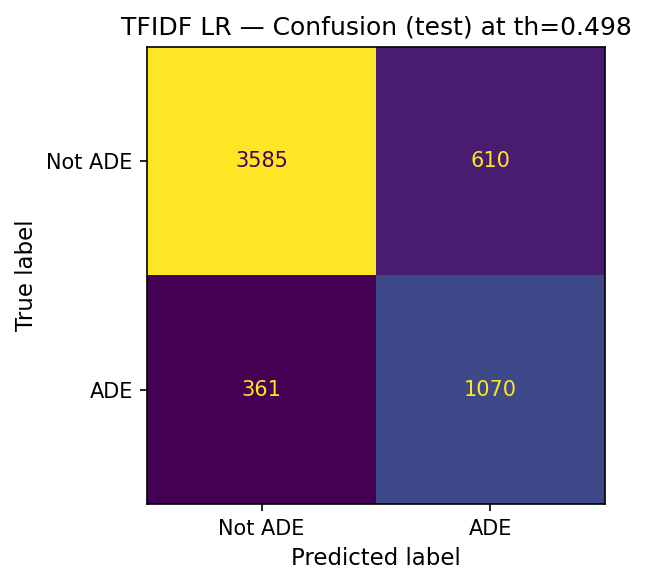

TN, FP, FN, TP = 3585 610 361 1070
Precision=0.637 | Recall=0.748 | F1=0.688 | Accuracy=0.827
Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/tfidf_lr_test_confusion.png


In [ ]:
with plt.rc_context({
    "figure.figsize": (11, 4),
    "savefig.dpi": 220,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10
}):
    lr_cm = cm_and_print(
        y_te, lr_te_p, lr_thr,
        f"TFIDF LR — Confusion (test) at th={lr_thr:.3f}",
        "tfidf_lr_test_confusion.png"
    )

Threshold near 0.498.
True negatives 3585, false positives 610, false negatives 361, true positives 1070.
Precision about 0.64, recall about 0.75, F1 about 0.69, accuracy about 0.83.
Recall is strong; most misses are false positives rather than false negatives.
Good operating point since recall is slightly more important than precision.

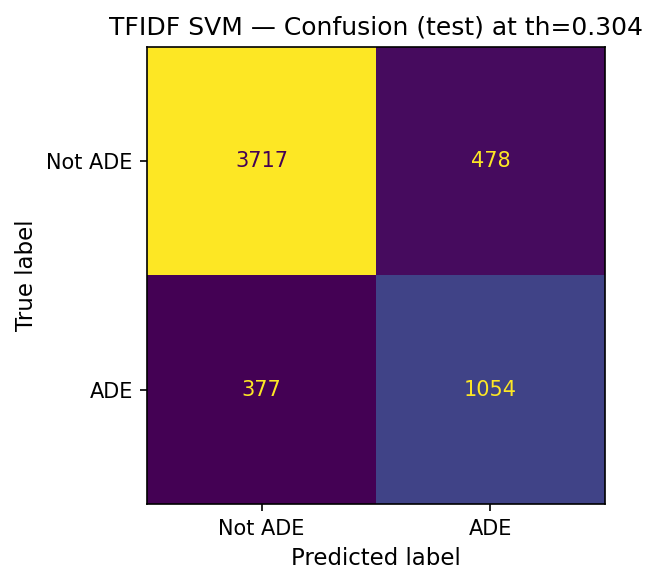

TN, FP, FN, TP = 3717 478 377 1054
Precision=0.688 | Recall=0.737 | F1=0.711 | Accuracy=0.848
Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/tfidf_svm_test_confusion.png


In [ ]:
with plt.rc_context({
    "figure.figsize": (11, 4),
    "savefig.dpi": 220,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10
}):
    svm_cm = cm_and_print(
        y_te, svm_te_p, svm_thr,
        f"TFIDF SVM — Confusion (test) at th={svm_thr:.3f}",
        "tfidf_svm_test_confusion.png"
    )


Threshold near 0.304.
True negatives 3717, false positives 478, false negatives 377, true positives 1054.
Precision about 0.69, recall about 0.74, F1 about 0.71, accuracy about 0.85.
Precision is higher than LR with similar recall.
Better option when you want fewer false positives.

# **save probs, metrics (VAL/TEST), models, vectorizer**

In [ ]:
# stable ids
va_ids = val_df["uid"].astype(str).values
te_ids = test_df["uid"].astype(str).values

# prediction CSVs
save_probs_csv(va_ids, y_va, lr_va_p,  TFIDF_DIR / "val_probs_lr.csv",  col_name="prob_lr")
save_probs_csv(te_ids, y_te, lr_te_p,  TFIDF_DIR / "test_probs_lr.csv", col_name="prob_lr")
save_probs_csv(va_ids, y_va, svm_va_p, TFIDF_DIR / "val_probs_svm.csv",  col_name="prob_svm")
save_probs_csv(te_ids, y_te, svm_te_p, TFIDF_DIR / "test_probs_svm.csv", col_name="prob_svm")

# models and vectorizer
joblib.dump(lr,  TFIDF_DIR / "logreg_model.joblib")
joblib.dump(svm, TFIDF_DIR / "linearsvc_calibrated.joblib")

# metrics packers
def pack_metrics(name, thr, yv, pv, yt, pt):
    yv_hat = (pv >= thr).astype(int)
    yt_hat = (pt >= thr).astype(int)
    Pv, Rv, Fv, _ = precision_recall_fscore_support(yv, yv_hat, average="binary", zero_division=0)
    Pt, Rt, Ft, _ = precision_recall_fscore_support(yt, yt_hat, average="binary", zero_division=0)
    return {
        "model": name,
        "val":  {"threshold": float(thr), "precision": float(Pv), "recall": float(Rv), "f1": float(Fv),
                 "pr_auc": float(average_precision_score(yv, pv)), "roc_auc": float(roc_auc_score(yv, pv))},
        "test": {"threshold": float(thr), "precision": float(Pt), "recall": float(Rt), "f1": float(Ft),
                 "pr_auc": float(average_precision_score(yt, pt)), "roc_auc": float(roc_auc_score(yt, pt))}
    }

save_json(pack_metrics("tfidf_logreg", lr_thr,  y_va, lr_va_p,  y_te, lr_te_p),  TFIDF_DIR / "metrics_lr.json")
save_json(pack_metrics("tfidf_svm",    svm_thr, y_va, svm_va_p, y_te, svm_te_p), TFIDF_DIR / "metrics_svm.json")

save_json({"lr": lr_cm, "svm": svm_cm}, TFIDF_DIR / "confusion_test.json")
print("Saved artifacts to:", TFIDF_DIR)


Saved artifacts to: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/baselines/tfidf


# **PR/ROC plots (VAL + TEST)**

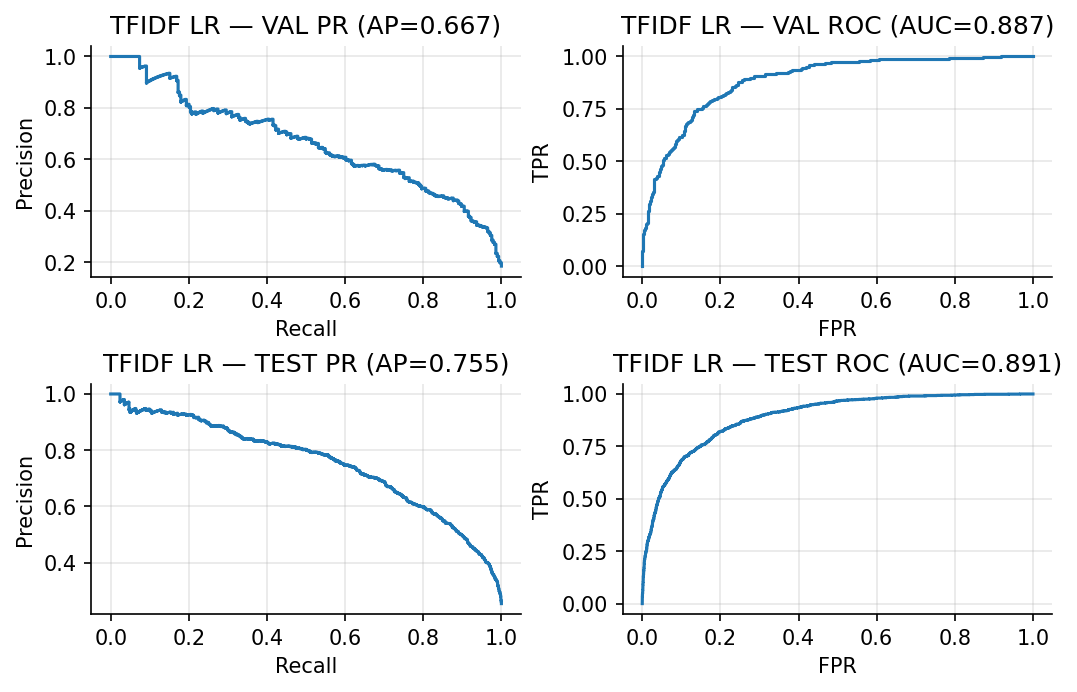

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/tfidf_lr_val_test_pr_roc_grid.png


In [ ]:
def plot_val_test_grid(y_va, p_va, y_te, p_te, model_name: str, out_path: Path):
    import matplotlib.pyplot as plt
    from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score

    # curves + areas
    pr_p_va, pr_r_va, _ = precision_recall_curve(y_va, p_va)
    fpr_va, tpr_va, _   = roc_curve(y_va, p_va)
    pr_p_te, pr_r_te, _ = precision_recall_curve(y_te, p_te)
    fpr_te, tpr_te, _   = roc_curve(y_te, p_te)

    ap_va  = average_precision_score(y_va, p_va)
    ap_te  = average_precision_score(y_te, p_te)
    auc_va = auc(fpr_va, tpr_va)
    auc_te = auc(fpr_te, tpr_te)

    fig, axes = plt.subplots(2, 2, figsize=(7, 4.5), constrained_layout=True)

    # VAL PR
    ax = axes[0, 0]
    ax.step(pr_r_va, pr_p_va, where="post")
    ax.set_title(f"{model_name} — VAL PR (AP={ap_va:.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.grid(alpha=0.3); [ax.spines[s].set_visible(False) for s in ("top","right")]

    # VAL ROC
    ax = axes[0, 1]
    ax.plot(fpr_va, tpr_va)
    ax.set_title(f"{model_name} — VAL ROC (AUC={auc_va:.3f})")
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.grid(alpha=0.3); [ax.spines[s].set_visible(False) for s in ("top","right")]

    # TEST PR
    ax = axes[1, 0]
    ax.step(pr_r_te, pr_p_te, where="post")
    ax.set_title(f"{model_name} — TEST PR (AP={ap_te:.3f})")
    ax.set_xlabel("Recall"); ax.set_ylabel("Precision")
    ax.grid(alpha=0.3); [ax.spines[s].set_visible(False) for s in ("top","right")]

    # TEST ROC
    ax = axes[1, 1]
    ax.plot(fpr_te, tpr_te)
    ax.set_title(f"{model_name} — TEST ROC (AUC={auc_te:.3f})")
    ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
    ax.grid(alpha=0.3); [ax.spines[s].set_visible(False) for s in ("top","right")]

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out_path)

# LR grid
plot_val_test_grid(y_va, lr_va_p, y_te, lr_te_p,
                   "TFIDF LR", PLOTS_DIR / "tfidf_lr_val_test_pr_roc_grid.png")


Validation AP about 0.667 and ROC AUC about 0.887.
Test AP about 0.755 and ROC AUC about 0.891.
Curves look consistent across splits, which suggests limited overfitting.
Ranking quality is solid even before picking a threshold.

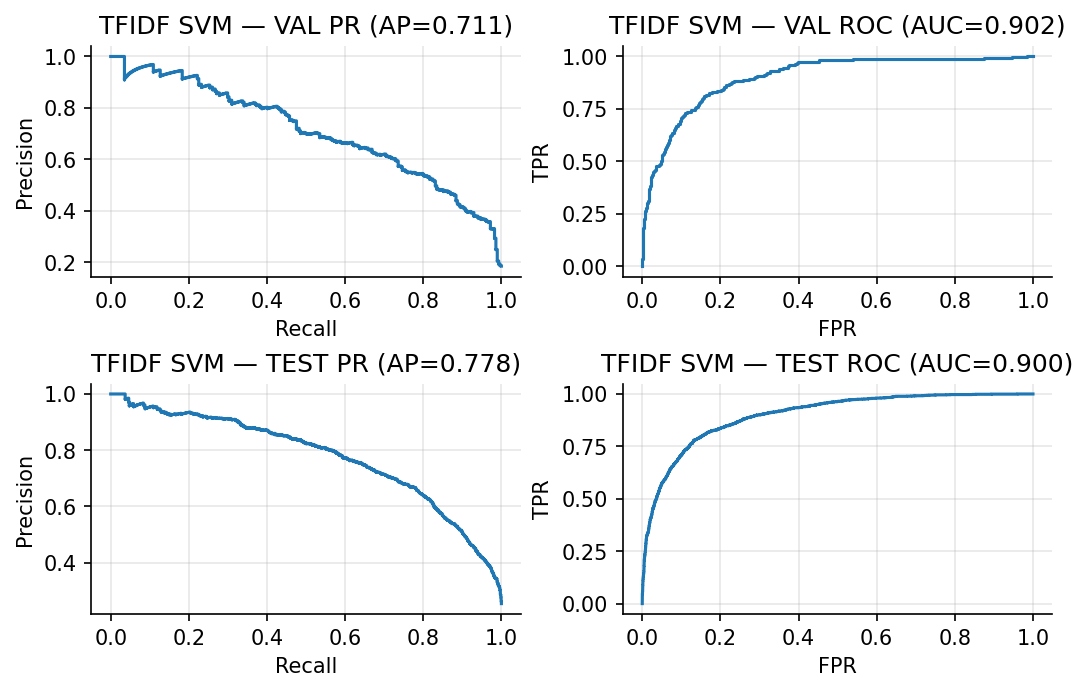

Saved: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/plots/tfidf_svm_val_test_pr_roc_grid.png


In [ ]:
# SVM grid
plot_val_test_grid(y_va, svm_va_p, y_te, svm_te_p,
                   "TFIDF SVM", PLOTS_DIR / "tfidf_svm_val_test_pr_roc_grid.png")


Validation AP about 0.711 and ROC AUC about 0.902.
Test AP about 0.778 and ROC AUC about 0.900.
Curves are slightly stronger than LR on both splits.
SVM is the stronger ranker among the baselines.

# **threshold sweep table (VAL) + sweep plots**

In [ ]:
RECALL_FLOOR = 0.915

def sweep_keep_table(y, p, floor=RECALL_FLOOR, grid=None):
    dfm = threshold_sweep(y, p, grid=grid)
    dfm["keep"] = dfm["recall"] >= floor
    return dfm[["threshold","precision","recall","f1","keep"]].sort_values("threshold", ascending=False)

lr_sweep  = sweep_keep_table(y_va, lr_va_p)
svm_sweep = sweep_keep_table(y_va, svm_va_p)

display(lr_sweep.head(12))
display(svm_sweep.head(12))


,threshold,precision,recall,f1,keep
18,0.95,1.000000,0.021127,0.041379,False
17,0.90,0.961538,0.088028,0.161290,False
16,0.85,0.923077,0.169014,0.285714,False
15,0.80,0.783784,0.204225,0.324022,False
14,0.75,0.775000,0.327465,0.460396,False
13,0.70,0.756410,0.415493,0.536364,False
12,0.65,0.681592,0.482394,0.564948,False
11,0.60,0.621094,0.559859,0.588889,False
10,0.55,0.578125,0.651408,0.612583,False
9,0.50,0.556150,0.732394,0.632219,False


,threshold,precision,recall,f1,keep
18,0.95,0.947368,0.063380,0.118812,False
17,0.90,0.939394,0.109155,0.195584,False
16,0.85,0.937500,0.158451,0.271084,False
15,0.80,0.925373,0.218310,0.353276,False
14,0.75,0.870588,0.260563,0.401084,False
13,0.70,0.821429,0.323944,0.464646,False
12,0.65,0.797101,0.387324,0.521327,False
11,0.60,0.783951,0.447183,0.569507,False
10,0.55,0.725806,0.475352,0.574468,False
9,0.50,0.697115,0.510563,0.589431,False


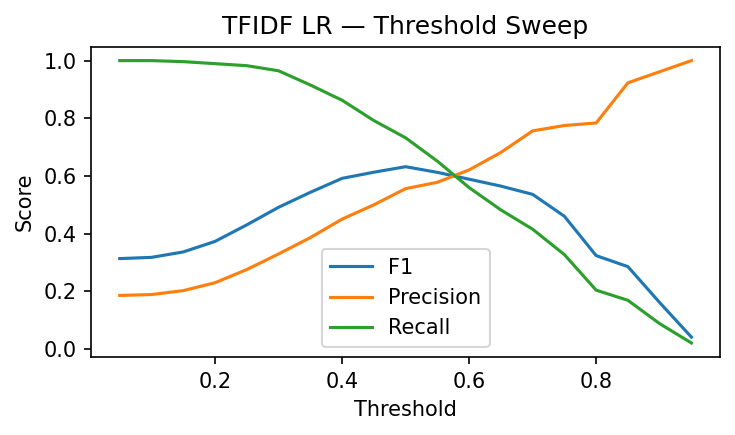

In [ ]:
_old = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (5, 3)
plot_threshold_sweep(lr_sweep, PLOTS_DIR / "tfidf_lr_thr_sweep.png", title="TFIDF LR — Threshold Sweep")
plt.rcParams["figure.figsize"] = _old


Precision rises as the threshold increases; recall falls.
F1 peaks around the middle of the range, near the chosen threshold.


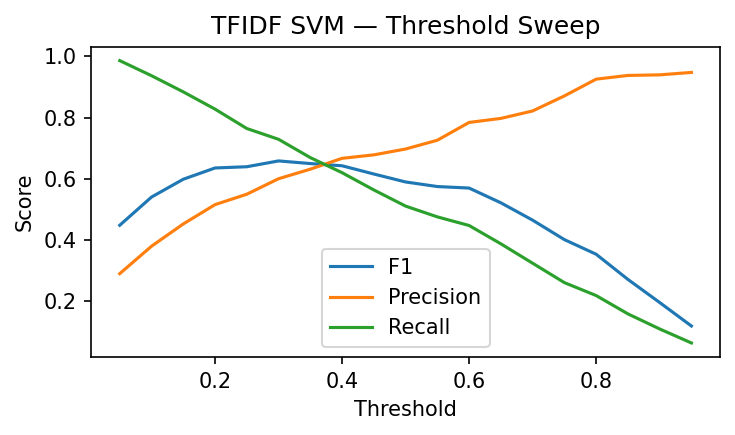

In [ ]:
_old = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (5, 3)
plot_threshold_sweep(svm_sweep, PLOTS_DIR / "tfidf_svm_thr_sweep.png", title="TFIDF SVM — Threshold Sweep")
plt.rcParams["figure.figsize"] = _old

Same trade-off pattern as LR.
F1 peaks near 0.3 to 0.35, matching the chosen threshold near 0.304.

If we enforce a recall floor above about 0.90, then we need lower threshold with lower precision.

# **calibration (TEST) + Brier**

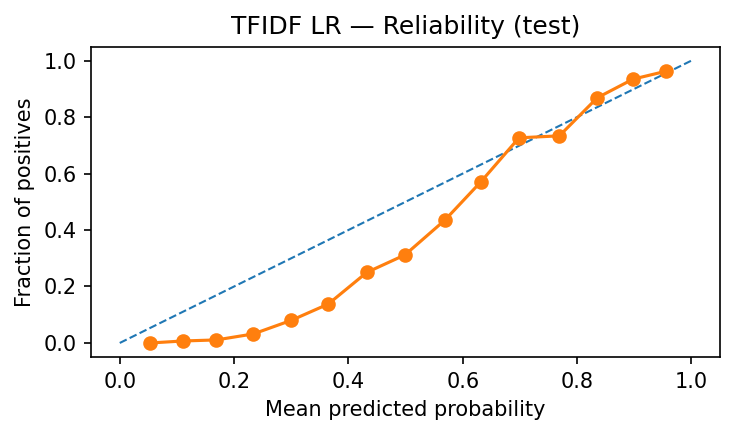

In [ ]:
def calib_block(y, p, name, out_stem):
    plot_calibration(y, p, PLOTS_DIR / f"{out_stem}_calibration.png", n_bins=15, title=f"{name} — Reliability (test)")
    brier = brier_score_loss(y, p)
    print(f"{name} — Brier(test) = {brier:.3f} | saved ->", PLOTS_DIR / f"{out_stem}_calibration.png")

with plt.rc_context({'figure.figsize': (5, 3)}):
    plot_calibration(y_te, lr_te_p,  PLOTS_DIR / "tfidf_lr_test_calibration.png",
                     n_bins=15, title="TFIDF LR — Reliability (test)")


Under-confident in the middle probability bins and closer to the diagonal near the top end.

Use threshold tuning rather than raw scores for decisions.

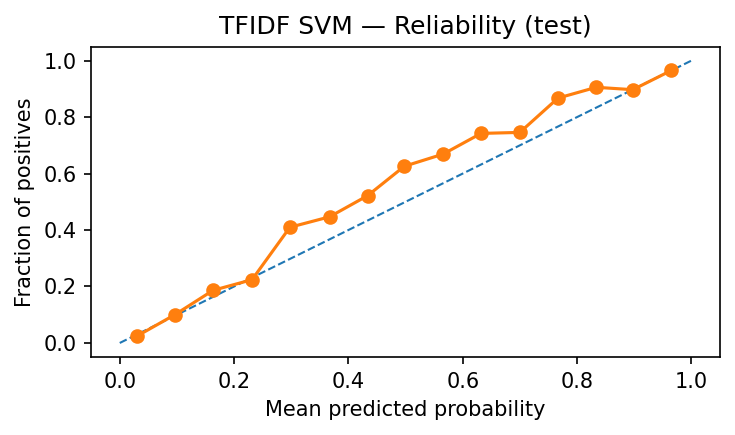

In [ ]:
with plt.rc_context({'figure.figsize': (5, 3)}):
    plot_calibration(y_te, svm_te_p, PLOTS_DIR / "tfidf_svm_test_calibration.png",
                     n_bins=15, title="TFIDF SVM — Reliability (test)")

Closer to the diagonal across most bins, with mild deviations at the extremes.

Probability outputs are more trustworthy for threshold selection.

# **compact summary**

In [ ]:
lr_val_ap  = average_precision_score(y_va, lr_va_p)
svm_val_ap = average_precision_score(y_va, svm_va_p)

def line(name, ap, thr, cm):
    return f"{name}: VAL AP={ap:.3f} | TEST at {thr:.3f} P={cm['precision']:.3f} R={cm['recall']:.3f} F1={cm['f1']:.3f} Acc={cm['accuracy']:.3f}"

print("=== TF-IDF Baselines (summary) ===")
print(line("LR",  lr_val_ap,  lr_thr,  lr_cm))
print(line("SVM", svm_val_ap, svm_thr, svm_cm))

print("\nArtifacts:")
print(" - probs csvs:", TFIDF_DIR / "val_probs_lr.csv", TFIDF_DIR / "test_probs_lr.csv",
      TFIDF_DIR / "val_probs_svm.csv", TFIDF_DIR / "test_probs_svm.csv")
print(" - thresholds:", TFIDF_DIR / "lr_threshold.json", TFIDF_DIR / "svm_threshold.json")
print(" - metrics:", TFIDF_DIR / "metrics_lr.json", TFIDF_DIR / "metrics_svm.json")
print(" - models:", TFIDF_DIR / "logreg_model.joblib", TFIDF_DIR / "linearsvc_calibrated.joblib")
print(" - vectorizer:", TFIDF_DIR / "vectorizer.joblib")


=== TF-IDF Baselines (summary) ===
LR: VAL AP=0.667 | TEST at 0.498 P=0.637 R=0.748 F1=0.688 Acc=0.827
SVM: VAL AP=0.711 | TEST at 0.304 P=0.688 R=0.737 F1=0.711 Acc=0.848

Artifacts:
 - probs csvs: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/baselines/tfidf/val_probs_lr.csv /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/baselines/tfidf/test_probs_lr.csv /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/baselines/tfidf/val_probs_svm.csv /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/baselines/tfidf/test_probs_svm.csv
 - thresholds: /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/baselines/tfidf/lr_threshold.json /content/drive/MyDrive/masters_math/capestone/Final_project/Final_project/artifacts/baselines/tfidf/svm_threshold.json
 - metrics: /content/drive/MyDrive/masters_math/capestone/Final_project/Final